## Environment check

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.9.1+cu128
False


imports & global config (skeleton)

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets,transforms

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Reproducibility

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_size = int(0.9*len(train_dataset))
val_size = len(train_dataset)-train_size

train_dataset,val_dataset = torch.utils.data.random_split(
    train_dataset,[train_size,val_size]
)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
test_dataset = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)


In [5]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,256)
        self.fc2=nn.Linear(256,128)
        self.fc3=nn.Linear(128,64)
        self.fc4=nn.Linear(64,10)
    def forward(self, x):
        x=x.view(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.fc4(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)

print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3
)

In [8]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

In [9]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs,labels)

            running_loss += loss.item()*images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds==labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct/len(loader.dataset)

    return epoch_loss,accuracy

In [10]:
num_epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(
        model,train_loader,optimizer,criterion,device
    )
    val_loss,val_acc = evaluate(
        model,val_loader, criterion,device
    )
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f} "
        f"Val Loss: {val_loss:.4f} "
        f"Val Acc: {val_acc:.4f}"
    )  


Epoch [1/10] Train Loss: 0.4097 Val Loss: 0.1957 Val Acc: 0.9458
Epoch [2/10] Train Loss: 0.1483 Val Loss: 0.1506 Val Acc: 0.9530
Epoch [3/10] Train Loss: 0.1001 Val Loss: 0.1103 Val Acc: 0.9672
Epoch [4/10] Train Loss: 0.0735 Val Loss: 0.1066 Val Acc: 0.9693
Epoch [5/10] Train Loss: 0.0556 Val Loss: 0.1067 Val Acc: 0.9712
Epoch [6/10] Train Loss: 0.0450 Val Loss: 0.0984 Val Acc: 0.9713
Epoch [7/10] Train Loss: 0.0344 Val Loss: 0.0933 Val Acc: 0.9740
Epoch [8/10] Train Loss: 0.0289 Val Loss: 0.0918 Val Acc: 0.9730
Epoch [9/10] Train Loss: 0.0213 Val Loss: 0.0876 Val Acc: 0.9743
Epoch [10/10] Train Loss: 0.0199 Val Loss: 0.1081 Val Acc: 0.9720


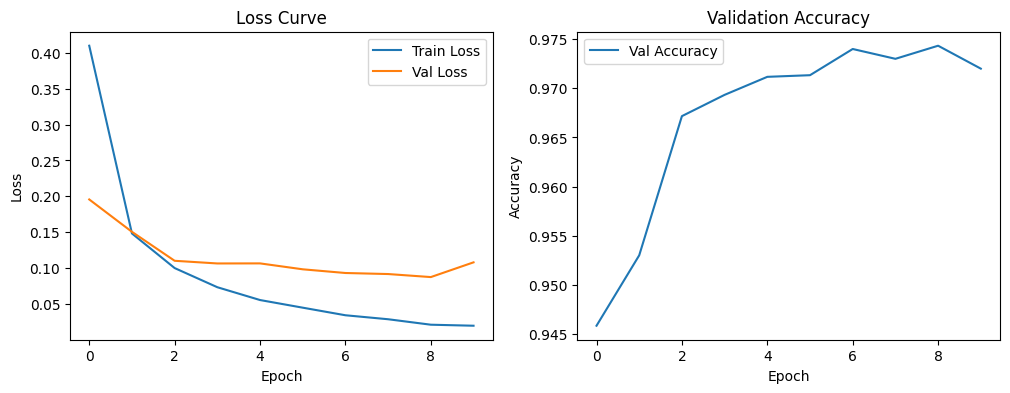

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy")

plt.show()


In [12]:
look_in = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

In [13]:
print(look_in)

In [44]:
for images, labels in look_in:
    a=images[0][0]
    b=labels[0]
    break
print(images.shape)
print(labels.shape)
print(a.shape)
print(b.shape)
print(images.view(images.size(0),-1).shape)
print(type(images))

torch.Size([128, 1, 28, 28])
torch.Size([128])
torch.Size([28, 28])
torch.Size([])
torch.Size([128, 784])
<class 'torch.Tensor'>


In [59]:
train_play=DataLoader(dataset=train_dataset,batch_size=64,shuffle=True)

In [98]:
for i,l in train_play:
    print(l)
    break

tensor([4, 3, 5, 7, 0, 0, 3, 4, 5, 2, 7, 1, 6, 2, 2, 9, 8, 5, 0, 0, 0, 1, 2, 2,
        8, 4, 9, 8, 3, 0, 7, 1, 0, 4, 6, 5, 9, 2, 2, 0, 0, 6, 9, 8, 0, 4, 0, 1,
        4, 7, 7, 0, 0, 0, 8, 9, 1, 3, 1, 4, 9, 9, 2, 4])


In [ ]:
counterr=0
for i,l in train_play:
    counterr+=1
print(counterr)

844


In [62]:
type(train_dataset[0])

tuple

In [96]:
train_dataset[0][1]

6

In [114]:
op1=model(train_dataset[0][0])

In [115]:
print(len(op1[0]))

10


In [116]:
for i in range(len(op1[0])):
    print(i,op1[0][i])

0 tensor(-0.2244, grad_fn=<SelectBackward0>)
1 tensor(-11.6607, grad_fn=<SelectBackward0>)
2 tensor(-3.9036, grad_fn=<SelectBackward0>)
3 tensor(-4.1202, grad_fn=<SelectBackward0>)
4 tensor(-7.7831, grad_fn=<SelectBackward0>)
5 tensor(-0.7515, grad_fn=<SelectBackward0>)
6 tensor(8.5232, grad_fn=<SelectBackward0>)
7 tensor(-20.9270, grad_fn=<SelectBackward0>)
8 tensor(1.4823, grad_fn=<SelectBackward0>)
9 tensor(-5.6136, grad_fn=<SelectBackward0>)


In [117]:
answer = 6
t_answer = torch.tensor(answer,dtype=torch.long)
print(t_answer)
t_answer=t_answer.unsqueeze(0)
print(t_answer)

tensor(6)
tensor([6])


In [118]:
loss1=criterion(op1,t_answer)

In [119]:
print(loss1)

tensor(0.0011, grad_fn=<NllLossBackward0>)


In [120]:
optimizer.zero_grad()

In [121]:
print(loss1.backward())

None


In [122]:
optimizer.step()